In [27]:
import geopandas as gpd
import numpy as np
import shapely

In [28]:
N_SQUARES = 40
SQUARE_WIDTH = 0.2
N_CLASSES = 4

Create dummy data

<Axes: >

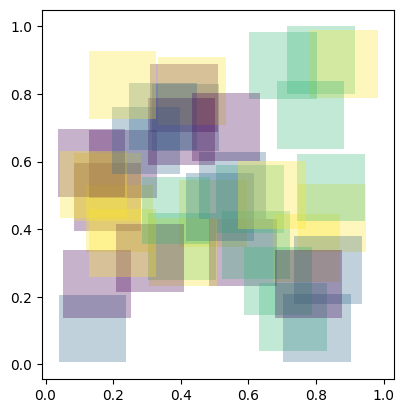

In [29]:
tl_corners = np.random.random((N_SQUARES, 2)) * (1 - SQUARE_WIDTH)
boxes = [shapely.box(tl[0], tl[1], tl[0] + SQUARE_WIDTH, tl[1] + SQUARE_WIDTH) for tl in tl_corners]
classes = np.random.randint(0, N_CLASSES, size=N_SQUARES)

classified_polygons = gpd.GeoDataFrame({"geometry": boxes, "classes": classes})
classified_polygons.plot("classes",alpha=0.3)

0    0.000022
1    0.002806
2    0.001377
Name: area, dtype: float64
[0, 2, 1]
     3    0    2    1
0  1.0  1.0  1.0  1.0
1  2.0  1.0  1.0  1.0
2  1.0  1.0  2.0  1.0
3  2.0  1.0  2.0  1.0
4  1.0  1.0  1.0  2.0
5  2.0  1.0  1.0  2.0
6  1.0  1.0  2.0  2.0
7  2.0  1.0  2.0  2.0
0    3
1    3
2    2
3    3
4    1
5    3
6    2
7    3
dtype: object


/ofo-share/repos-david/conda/envs/scientific-python-utils/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


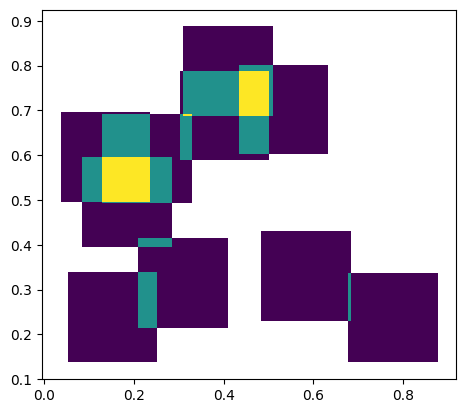

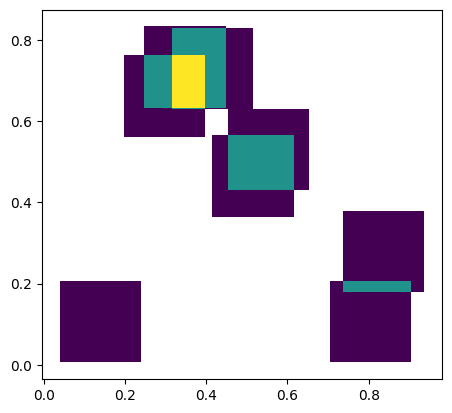

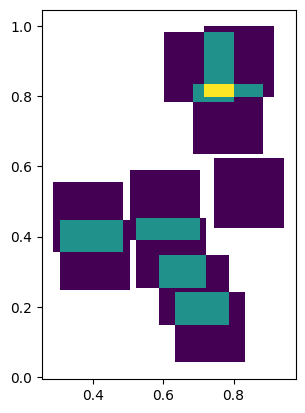

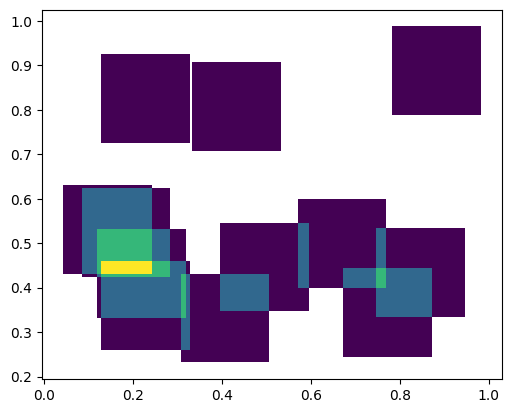

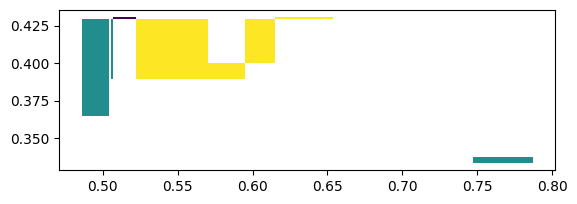

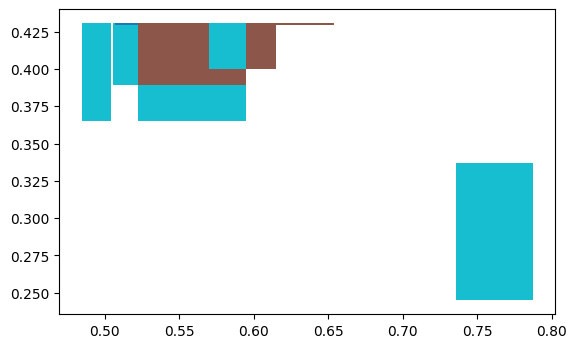

In [55]:
import matplotlib.pyplot as plt
def merge_classified_polygons(classified_polygons, class_column=None):
    grouped = {k[0]:v for k, v in classified_polygons.groupby([class_column])}

    unique_classes = list(grouped.keys())

    counts_overlays = []

    for k, v in grouped.items():
        v.drop("classes", axis=1, inplace=True)
        v["counts"] = 1

        overlay = v.iloc[0:1]

        for i in range(1, len(v)):
            overlay = gpd.overlay(overlay, v.iloc[i:i+1], how="union")
            overlay.fillna(0, inplace=True)
            overlay["counts"] = overlay["counts_1"] + overlay["counts_2"]
            overlay.drop(["counts_1", "counts_2"], axis=1, inplace=True)
        overlay = overlay.dissolve("counts", as_index=False)
        overlay[k] = overlay["counts"]
        overlay.plot("counts")
        overlay.drop("counts", axis=1, inplace=True)

        counts_overlays.append(overlay)

    votes_per_class = counts_overlays[0]

    for single_class_overlay in counts_overlays[1:]:
        votes_per_class = votes_per_class.overlay(single_class_overlay)

    class_counts_matrix = votes_per_class[unique_classes].values
    max_class_counts = np.max(class_counts_matrix, axis=1, keepdims=True)

    # Find rows where one class has the most votes
    one_max_class = np.sum(max_class_counts == class_counts_matrix, axis=1) == 1

    # Extract rows where one class has the most votes
    rows_with_one_class = votes_per_class.iloc[one_max_class]
    # Label them with the max class
    rows_with_one_class["max_class"] = rows_with_one_class[unique_classes].idxmax(axis=1)
    # Dissolve all polygons so we have one (multi)polygon per class
    rows_with_one_class = rows_with_one_class.dissolve("max_class", as_index=False)
    # Compute the area of each
    rows_with_one_class["area"] = rows_with_one_class.area
    rows_with_one_class.plot("area")


    print(rows_with_one_class["area"])
    sorted_inds = (rows_with_one_class["area"]).argsort()
    sorted_classes = rows_with_one_class.index[sorted_inds].tolist()
    print(sorted_classes)

    # Determine which classes (if any) have no non-overlapping regions. Add them to the start of the
    # list
    zero_area_classes = [c for c in unique_classes if c not in sorted_classes]
    # Prepend the classes to the beginning of the list of sorted classes
    sorted_classes = zero_area_classes + sorted_classes

    # Get the new order of column names
    print(votes_per_class[sorted_classes])
    max_class = votes_per_class[sorted_classes].idxmax(axis=1)
    print(max_class)
    votes_per_class["max_class"] = max_class
    votes_per_class.plot("max_class")

merge_classified_polygons(classified_polygons=classified_polygons, class_column="classes")